In [147]:
import os
import pandas as pd, numpy as np
import pickle
from scipy.stats import probplot
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

In [148]:
# 경로 정의하기
dataPath = os.path.join(os.getcwd(), '..', '..', 'Dataset')
fname = os.path.join(dataPath, 'PRADA_cocktail_list.json')

# 데이터 불러오기
df = getDataframe(fname)

# df[Name]에 '-d'가 포함된 데이터 제거하기
df = df[~df['Name'].str.contains('-d')]

df.reset_index(drop=True, inplace=True)

# 재료 비율 구하기
df_ratio = getCocktailRatio(df, 'Ingredients')

# 재료 비율 데이터프레임 확인하기
df_ratio.head()


,ID,Name,Irish whiskey,absinthe,amaretto,apple,apple liquer,apricot brandy,baileys,bitters,...,tabasco,tequila,tomato juice,tonic water,vodka,water,whipped cream,whiskey,white rum (light rum),worcestershire sauce
0,0,Alexander,0.0,0.0,0.000000,0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.000000,0.0
1,1,Amaretto Sour,0.0,0.0,0.454545,0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,2,Americano,0.0,0.0,0.000000,0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3,8,B-52,0.0,0.0,0.000000,0,0.0,0.0,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,9,Bacardi,0.0,0.0,0.000000,0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.588235,0.0


In [149]:
df_ratio2 = df_ratio.drop(['ID', 'Name'], axis=1)

## 정규성 검정하기

### 1) 시각화 방식으로 검정하기

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 73 samples in 0.000s...
[t-SNE] Computed neighbors for 73 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 73 / 73
[t-SNE] Mean sigma: 0.254235
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.987534
[t-SNE] KL divergence after 3000 iterations: 0.474423
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 73 samples in 0.000s...
[t-SNE] Computed neighbors for 73 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 73 / 73
[t-SNE] Mean sigma: 0.337881
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.890228
[t-SNE] KL divergence after 1050 iterations: 0.446027
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 73 samples in 0.000s...
[t-SNE] Computed neighbors for 73 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 73 / 73
[t-SNE] Mean sigma: 0.413858
[t-SNE] KL divergence after 250 iterations with earl

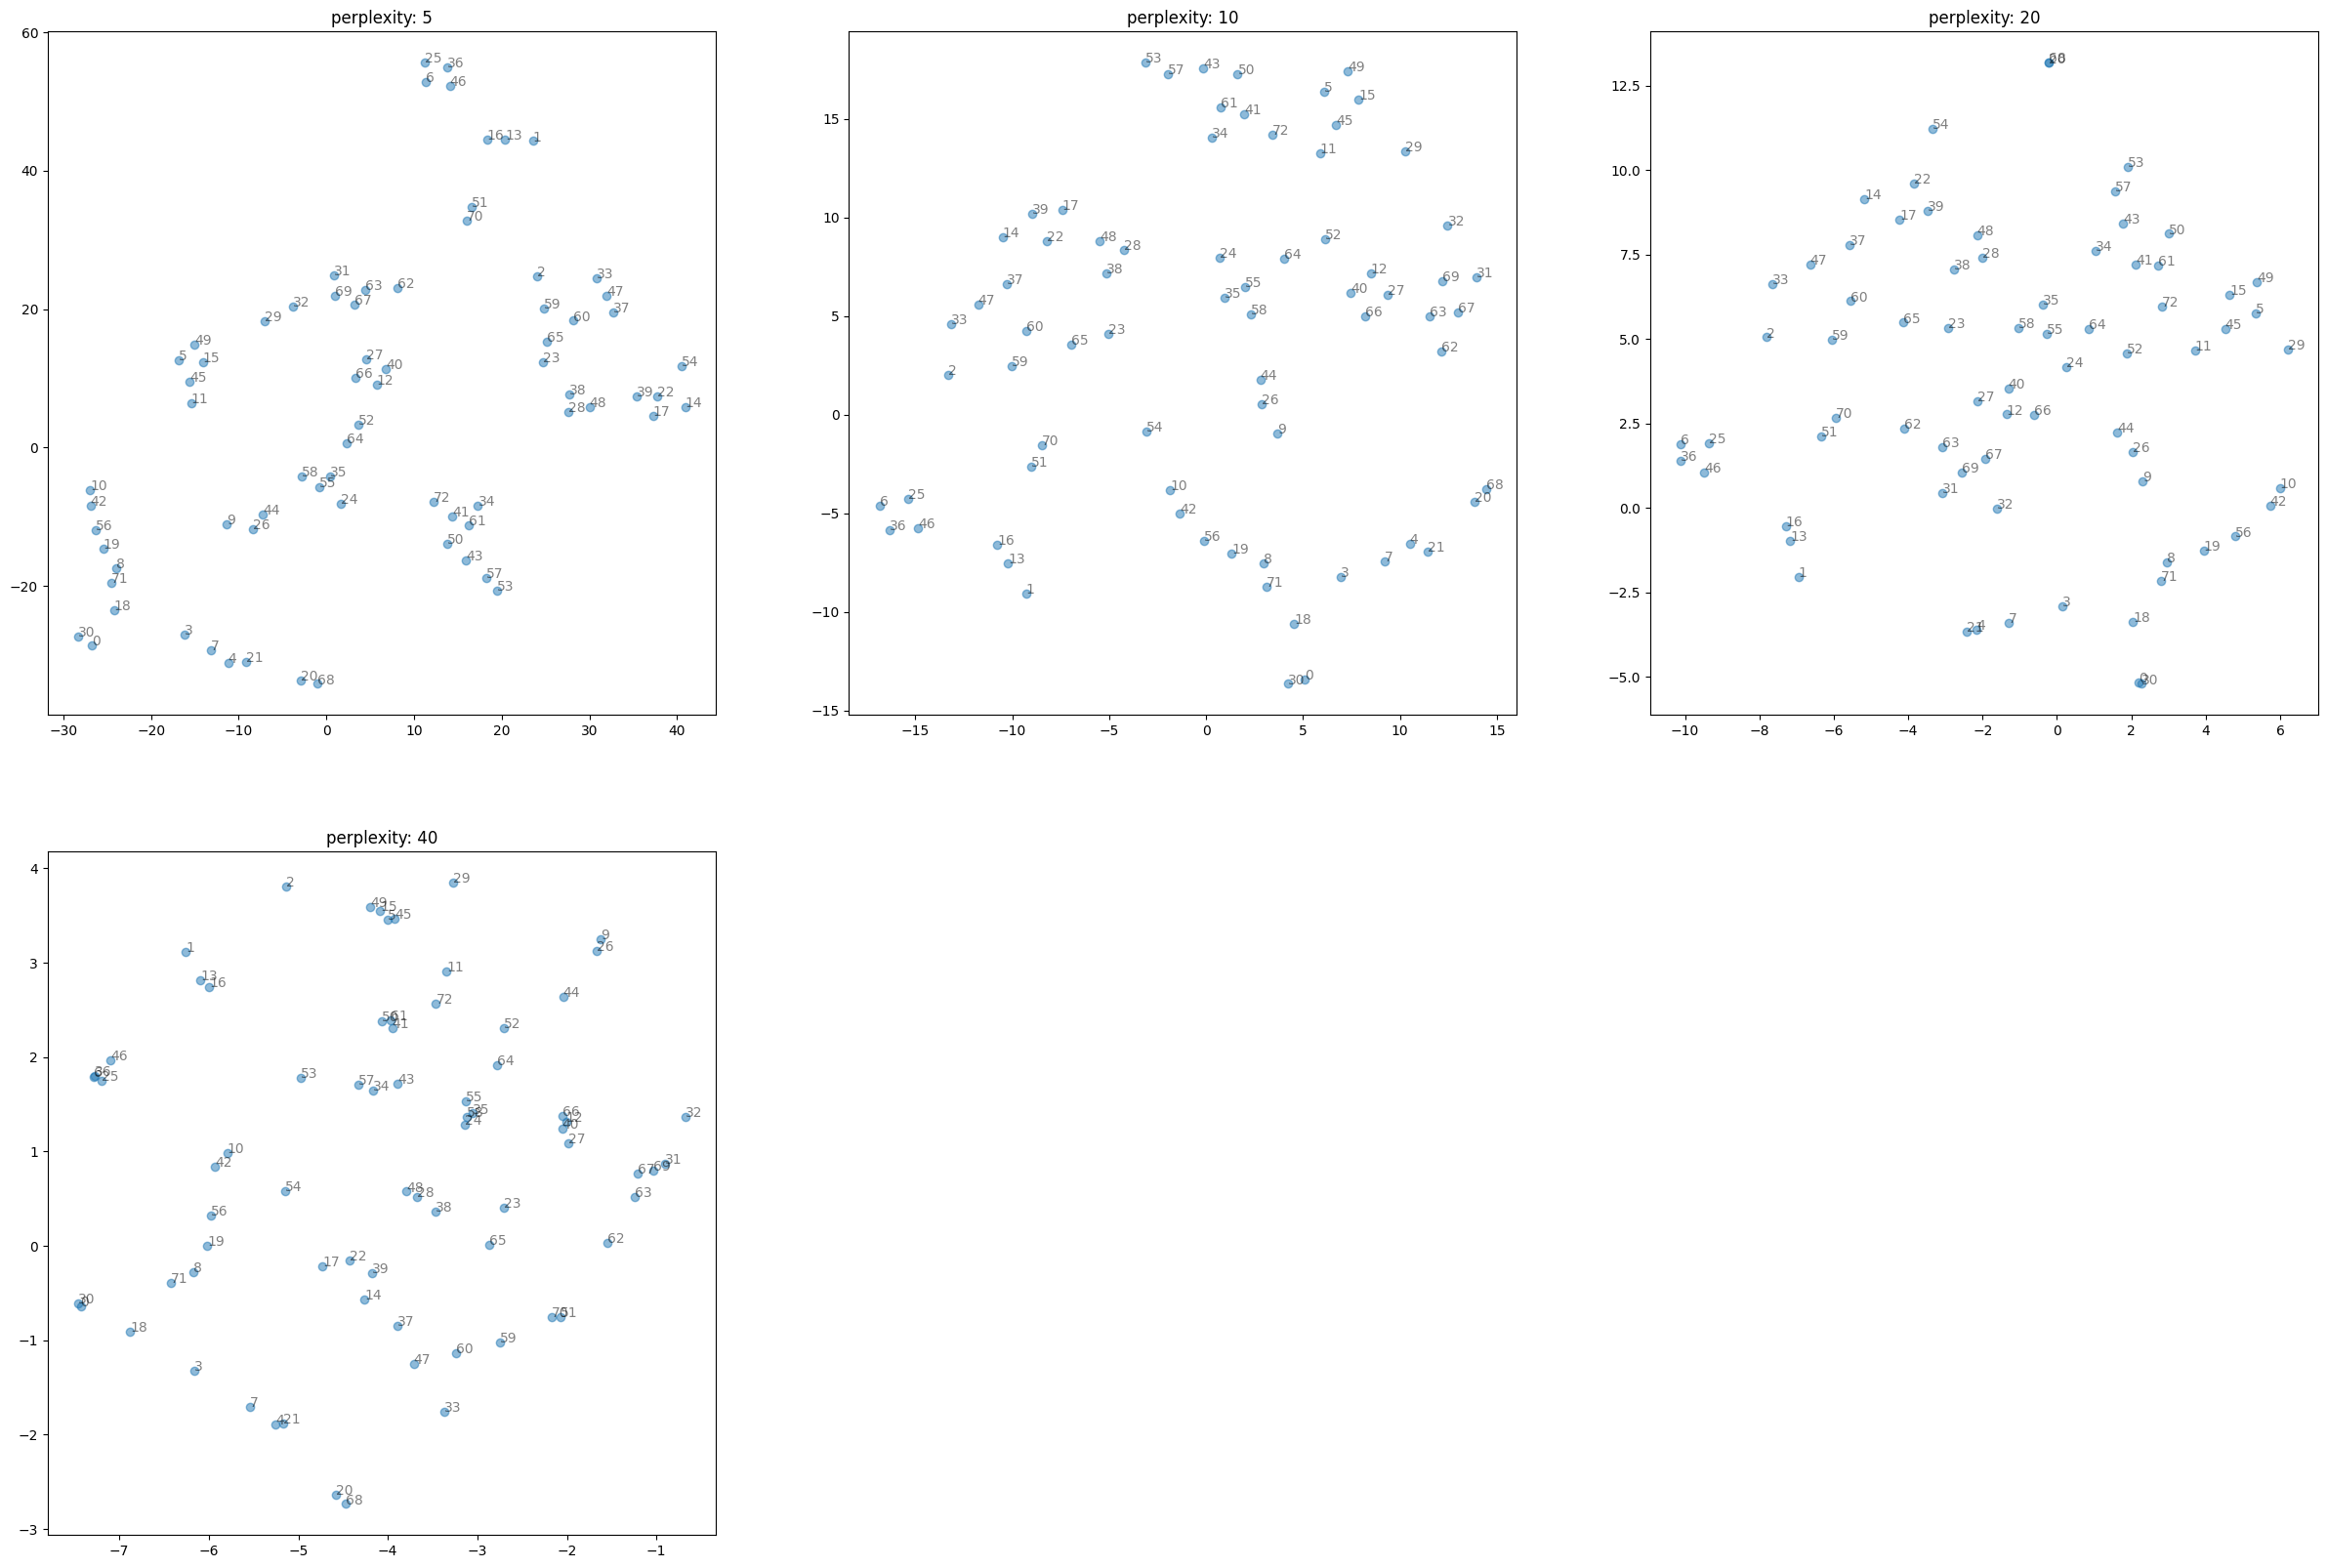

In [150]:
# t-SNE를 이용한 시각화

# cosine similarity
from similarity import cosim

perplexs = [5, 10, 20, 40]

plt.figure(figsize=(30, 20))
for perp in perplexs:
    tsne = TSNE(n_components=2, random_state=100, perplexity=perp, n_iter=8000, metric='cosine', verbose=1) # angle = 0.5
    tsne_data = tsne.fit_transform(df_ratio2)

    # subplot 시각화
    plt.subplot(2, 3, perplexs.index(perp)+1)
    plt.title('perplexity: {}'.format(perp))

    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.5)


    for i in range(len(df_ratio2)):
        plt.text(tsne_data[i, 0], tsne_data[i, 1], str(df_ratio2.index[i]), 
                fontsize=10, color='k', alpha=0.5)
    

plt.show()




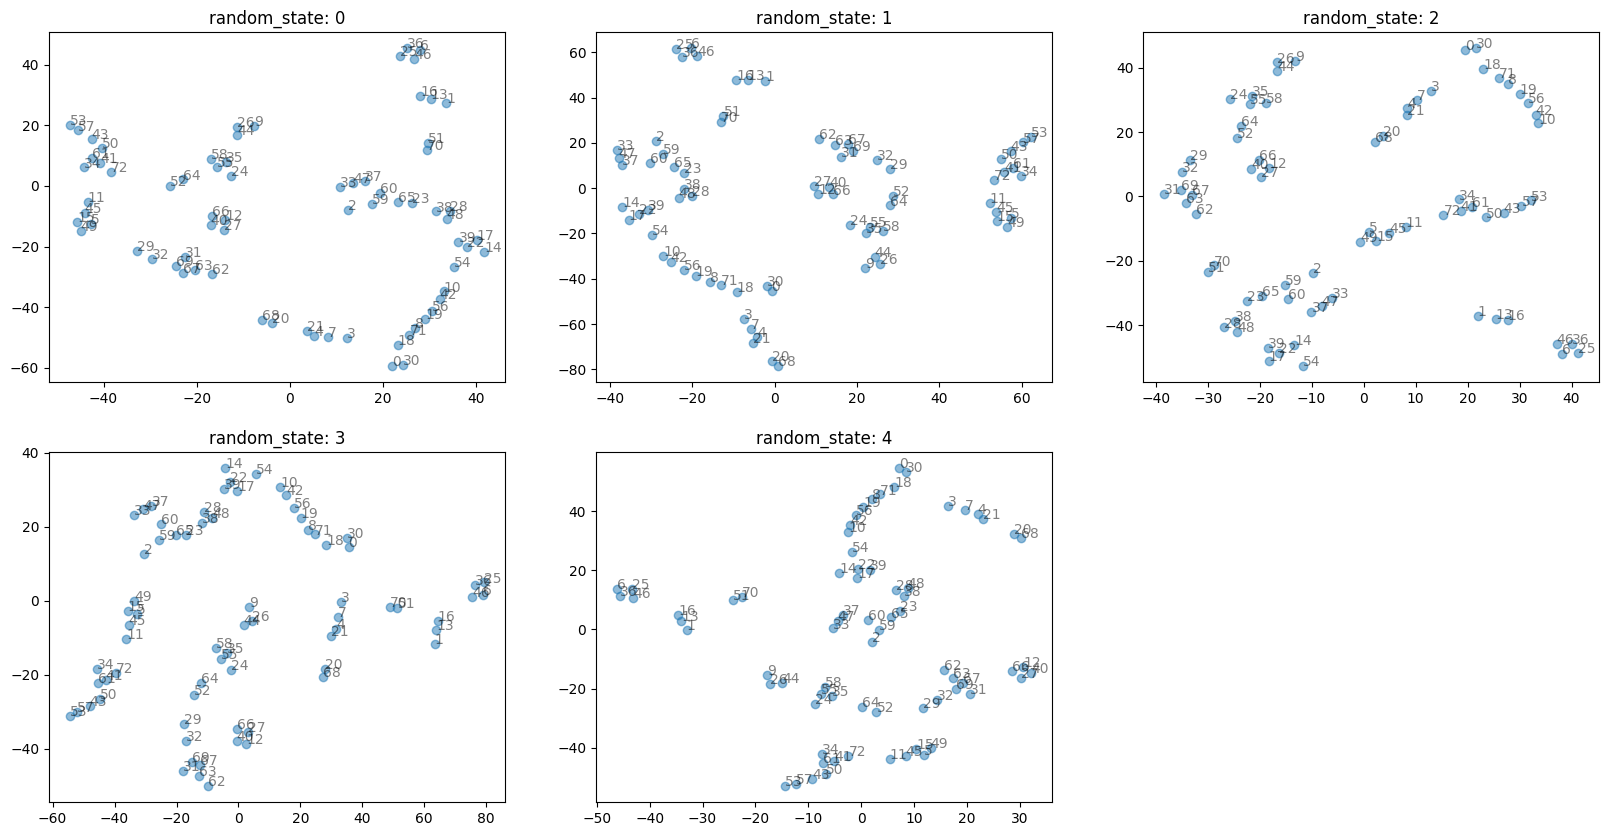

In [151]:
# perplexity = 5로 고정, 5번 반복 결과를 그래프로 시각화
plt.figure(figsize=(20, 10))
for i in range(5):
    tsne = TSNE(n_components=2, perplexity=4, n_iter=8000, metric='cosine', angle=0.5) # angle = 0.5
    tsne_data = tsne.fit_transform(df_ratio2)

    # subplot 시각화
    plt.subplot(2, 3, i+1)
    plt.title('random_state: {}'.format(i))

    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.5)

    for i in range(len(df_ratio2)):
        plt.text(tsne_data[i, 0], tsne_data[i, 1], str(df_ratio2.index[i]), 
                fontsize=10, color='k', alpha=0.5)


plt.show()




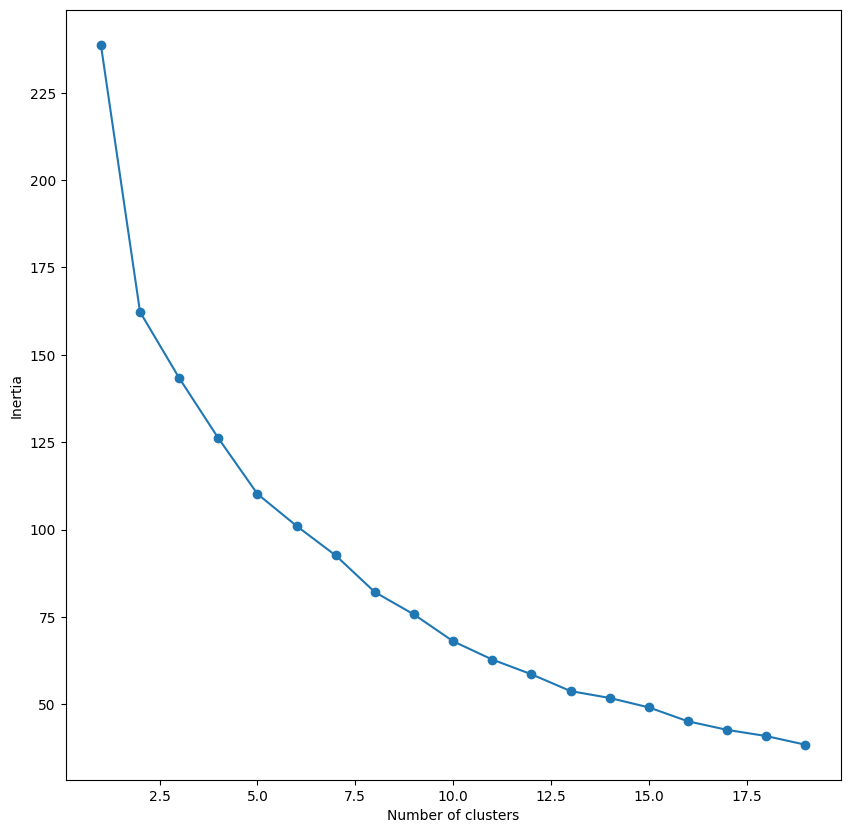

In [152]:
# k-means clustering

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(df_ratio2)

# elbow method
inertia_scores = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=1004)
    kmeans.fit(similarity_matrix)
    inertia_scores.append(kmeans.inertia_)
    

plt.figure(figsize=(10, 10))
plt.plot(range(1, 20), inertia_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [153]:
# cluster = 8로 설정

kmeans = KMeans(n_clusters=12, random_state=1004)
labels = kmeans.fit_predict(similarity_matrix)

# cluster 결과 확인

df_ratio2['cluster'] = labels


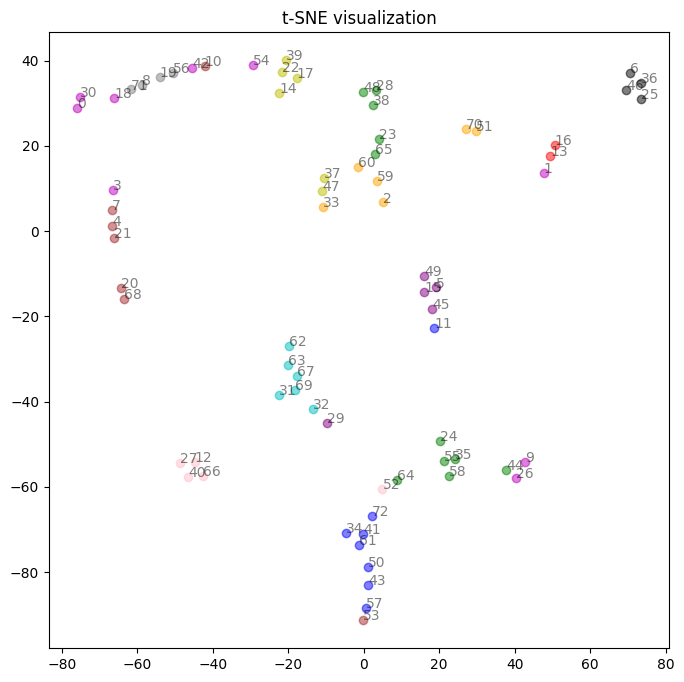

In [154]:
df_ratio3 = df_ratio2.drop(['cluster'], axis=1)

# t-SNE를 이용한 시각화
tsne = TSNE(n_components=2, perplexity=3, n_iter=20000, metric='cosine', angle=0.5) # angle = 0.5
tsne_data = tsne.fit_transform(df_ratio3)

# 각 label 별로 색상 지정
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'gray', 'brown', 'olive', 'cyan', 'lime', 'navy']

plt.figure(figsize=(8, 8))
plt.title('t-SNE visualization')

for i in range(len(df_ratio2)):
    plt.scatter(tsne_data[i, 0], tsne_data[i, 1], color=colors[df_ratio2['cluster'][i]], alpha=0.5)
    plt.text(tsne_data[i, 0], tsne_data[i, 1], str(df_ratio2.index[i]),
            fontsize=10, color='k', alpha=0.5)
    
plt.show()

In [155]:
df.shape

(73, 93)